# Hierarchical A* path finding algorithm

Created by - Sanjana Tule

Date - 19/08/2021


* **Implement weighted risk factor**. 

Give higher weightage to risk factors compared to length. As length = 10 and risk = 2 vs length = 2 and risk = 10 should not be the same.
Weighted Risk Factor = Length + 2 * ( Building Density Risk + Distance Risk)

* **Algorithm steps/description**:

Inspired and based on ideas in the paper - https://www.researchgate.net/publication/228785110_Near_optimal_hierarchical_path-finding_HPA

Hierarchical A* algorithm are sub-optimal compared to A* but they are faster. In life threatning situations they would be most suitable than traditional A* as A* finds the complete path before returning the navigation to the user. Compared to that Hierarchical A* only returns abstract navigation path and can calculate the subpaths in parallel while the user is navigating.

Assumptions:
1.   All Street are 2 way as for earthquake people would be walking or even one-way signs can be ignored for safety purposes
2.   For implemenation simplicity only 1 entrance/exit pair between clusters are considered. But in reality we may need to store all of them as the in-flight risk might change as people navigate.

**PART 1 - Pre-processing steps to create abstract graph**:

1.   Divide grid in C clusters.
2.   For each cluster C find entry/exit nodes n.
3.   Find edge between entry and exit nodes n - intraedges e.
4.   For  each nodes define an abstract inter edge m between them and the weighted risk.
5.   Create this abstract graph based on intra edges m, inter edges e and entry/exit nodes n.
6.   Test the abstract graph using the nodes in the graph


**PART 2 - Run-time steps ( search for path)**:

1.   Select the source s and destination d.
2.   Find the closest node from abstract graph a_s to s.
3.   Find the closest node from abstract graph d_s to d.
4.   Find the path betwen s and a_s in the original underlying detailed graph.
5.   Find the path betwen d and a_d in the original underlying detailed graph.
6.   Find the path between a_s and a_d in abstract graph.
7.   Plot all the paths together.


**PART 1 - PREPROCESSING - CREATE ABSTRACT GRAPH AND KEEP IT READY**



In [9]:
# !pip install osmnx
# !apt install python3-rtree

In [57]:
# import libraries
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import requests
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import math
from shapely.geometry import LineString, Point
import time

In [46]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# STEP 1 - load the graph,buildings and gdf from the disk

northridge_risk_factors_added_graph = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/1_northridge_graph_all_risk_added.pickle')
nodes_nr_all,edges_nr_all = ox.graph_to_gdfs(northridge_risk_factors_added_graph)
northridge_buildings = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/northridge_footprint.pickle')
northridge_gdf = nx.read_gpickle('/content/drive/My Drive/omdena/earthquake/northridge_gdf.pickle')

# calculate combined risk factor
W_distance_risk = 1
W_density_risk = 1
edges_nr_all['combined_risk'] = W_density_risk  * edges_nr_all['building_risk_score'] + W_distance_risk * edges_nr_all['distance_risk_score']

# calculate weighted risk
edges_nr_all['weighted_risk'] = 2  * edges_nr_all['combined_risk'] + 1 * edges_nr_all['length']

# pack it up in graph again for later use
northridge_risk_factors_added_graph = ox.graph_from_gdfs(nodes_nr_all,edges_nr_all)
nodes_nr_all,edges_nr_all = ox.graph_to_gdfs(northridge_risk_factors_added_graph)
display(edges_nr_all.head())
display(nodes_nr_all.head())

osmid_left           name  ... bridge tunnel
u          v          key                            ...              
29409715   6403348096 0     15240187   Chase Street  ...    NaN    NaN
           6403348105 0    400864518  Corbin Avenue  ...    NaN    NaN
           6403348099 0    400864506  Corbin Avenue  ...    NaN    NaN
6403348096 29409715   0     15240187   Chase Street  ...    NaN    NaN
           4269165902 0     15240187   Chase Street  ...    NaN    NaN

[5 rows x 18 columns]

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
29409715,34.224607,-118.562311,traffic_signals,4,NaN,POINT (-118.56231 34.22461)
6403348096,34.224607,-118.562177,NaN,4,NaN,POINT (-118.56218 34.22461)
6403348105,34.224528,-118.562312,NaN,4,NaN,POINT (-118.56231 34.22453)
6403348099,34.224686,-118.562311,NaN,4,NaN,POINT (-118.56231 34.22469)
4269165902,34.224610,-118.561699,NaN,3,NaN,POINT (-118.56170 34.22461)


In [48]:
# STEP 2 - divide the grid into clusters and find neighbours

# number of clusters
c = 4

display(northridge_gdf)
lon_diff =  northridge_gdf[['bbox_west']].values[0][0] -  northridge_gdf[['bbox_east']].values[0][0]
lat_diff = northridge_gdf[['bbox_north']].values[0][0] - northridge_gdf[['bbox_south']].values[0][0]
display("latitude diff",lat_diff)
display("longtitude diff",lon_diff)

lon_diff / 2
cluster_info = {}
n,s,e,w =  northridge_gdf[['bbox_north']].values[0][0], northridge_gdf[['bbox_north']].values[0][0] - (lat_diff / 2)   , northridge_gdf[['bbox_west']].values[0][0] - lon_diff/2 , northridge_gdf[['bbox_west']].values[0][0] 
cluster_info[1] = [n,s,e,w]
n,s,e,w =   northridge_gdf[['bbox_north']].values[0][0], northridge_gdf[['bbox_north']].values[0][0] - lat_diff / 2  , northridge_gdf[['bbox_east']].values[0][0], northridge_gdf[['bbox_west']].values[0][0] - lon_diff/2 
cluster_info[2] = [n,s,e,w]

n,s,e,w =   northridge_gdf[['bbox_north']].values[0][0] - lat_diff / 2 , northridge_gdf[['bbox_south']].values[0][0], northridge_gdf[['bbox_west']].values[0][0] - lon_diff/2 , northridge_gdf[['bbox_west']].values[0][0] 
cluster_info [3] = [n,s,e,w]
n,s,e,w =  northridge_gdf[['bbox_north']].values[0][0] - lat_diff / 2 , northridge_gdf[['bbox_south']].values[0][0] , northridge_gdf[['bbox_east']].values[0][0], northridge_gdf[['bbox_west']].values[0][0] - lon_diff/2 
cluster_info [4] = [n,s,e,w]

display("cluster info",cluster_info)

# find adjacent clusters

neighbor = []
for c_s in range(1,c+1):
  for c_e in range(c_s+1,c+1):
    # print(c_s)
    # print(c_e)
    if (cluster_info[c_s][0] == cluster_info[c_e][0]  and cluster_info[c_s][1] == cluster_info[c_e][1]) or (cluster_info[c_s][2] == cluster_info[c_e][2]  and cluster_info[c_s][3] == cluster_info[c_e][3]):
      neighbor.append((c_s,c_e))

display("neighbouring clusters",neighbor)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-118.56428 34.26059, -118.56426 34.2...",34.278403,34.22038,-118.491475,-118.564275,306436970,relation,7753455,34.234561,-118.536932,"Northridge, Los Angeles, California, United St...",boundary,administrative,0.638973


'latitude diff'

0.058022499999999866

'longtitude diff'

-0.0728004999999996

'cluster info'

{1: [34.2784028, 34.24939155, -118.52787485, -118.5642751],
 2: [34.2784028, 34.24939155, -118.4914746, -118.52787485],
 3: [34.24939155, 34.2203803, -118.52787485, -118.5642751],
 4: [34.24939155, 34.2203803, -118.4914746, -118.52787485]}

'neighbouring clusters'

[(1, 2), (1, 3), (2, 4), (3, 4)]

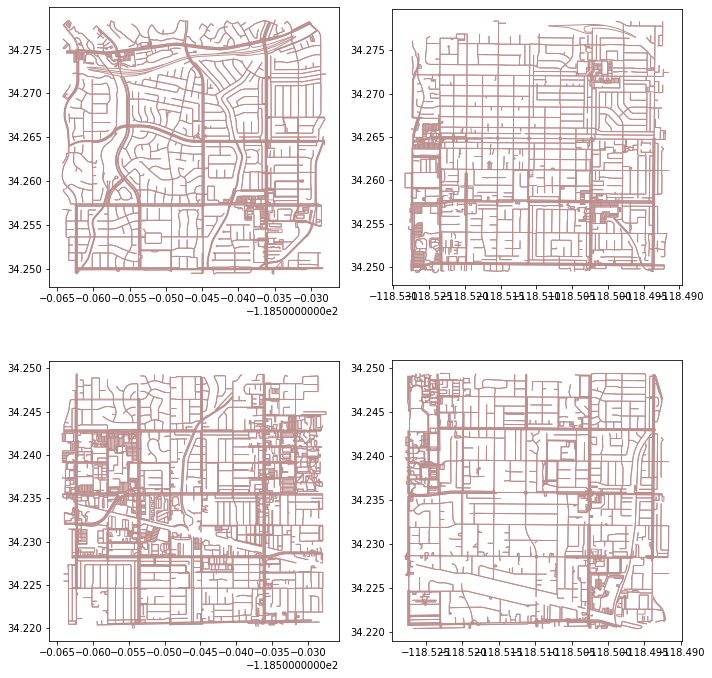

In [ ]:
# STEP 3 - display the clusters ( this may take a while)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,10))
cluster_1_graph = ox.graph_from_bbox(cluster_info[1][0],cluster_info[1][1],cluster_info[1][2],cluster_info[1][3])
nodes,edges = ox.graph_to_gdfs(cluster_1_graph)
edges.plot(ax=ax1, linewidth=1, edgecolor='#BC8F8F')

cluster_2_graph = ox.graph_from_bbox(cluster_info[2][0],cluster_info[2][1],cluster_info[2][2],cluster_info[2][3])
nodes,edges = ox.graph_to_gdfs(cluster_2_graph)
edges.plot(ax=ax2, linewidth=1, edgecolor='#BC8F8F')

cluster_3_graph = ox.graph_from_bbox(cluster_info[3][0],cluster_info[3][1],cluster_info[3][2],cluster_info[3][3])
nodes,edges = ox.graph_to_gdfs(cluster_3_graph)
edges.plot(ax=ax3, linewidth=1, edgecolor='#BC8F8F')

cluster_4_graph = ox.graph_from_bbox(cluster_info[4][0],cluster_info[4][1],cluster_info[4][2],cluster_info[4][3])
nodes,edges = ox.graph_to_gdfs(cluster_4_graph)
edges.plot(ax=ax4, linewidth=1, edgecolor='#BC8F8F')

plt.tight_layout()

Find all edges between cluster 1 and 2
Find all edges between cluster 1 and 3
Find all edges between cluster 2 and 4
Find all edges between cluster 3 and 4


,,,osmid_left,name,highway,maxspeed,oneway,length,geometry,distance_risk_score,building_risk_score,service,lanes,access,ref,width,bridge,tunnel,combined_risk,weighted_risk
u,v,key,,,,,,,,,,,,,,,,,,
6790327097,6317618456,0,674596857,NaN,footway,NaN,False,93.448,"LINESTRING (-118.52853 34.25715, -118.52755 34...",30,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,259.448
6317618456,6790327097,0,674596857,NaN,footway,NaN,False,93.448,"LINESTRING (-118.52751 34.25714, -118.52755 34...",30,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,259.448
364669636,122977133,0,13348237,Vanalden Avenue,tertiary,30 mph,False,74.936,"LINESTRING (-118.54922 34.24970, -118.54922 34...",26,79,NaN,2,NaN,NaN,NaN,NaN,NaN,105,284.936
122977133,364669636,0,13348237,Vanalden Avenue,tertiary,30 mph,False,74.936,"LINESTRING (-118.54922 34.24903, -118.54922 34...",26,79,NaN,2,NaN,NaN,NaN,NaN,NaN,105,284.936
122676367,123133229,0,13375759,Labrador Street,residential,NaN,False,79.659,"LINESTRING (-118.51731 34.24957, -118.51743 34...",26,107,NaN,2,NaN,NaN,NaN,NaN,NaN,133,345.659


,y,x,highway,street_count,ref,geometry,cluster,gateway
osmid,,,,,,,,
6790327097,34.2572,-118.529,NaN,4,NaN,POINT (-118.52853 34.25715),1.0,2.0
6317618456,34.2571,-118.528,NaN,4,NaN,POINT (-118.52751 34.25714),2.0,1.0
364669636,34.2497,-118.549,NaN,3,NaN,POINT (-118.54922 34.24970),1.0,3.0
122977133,34.249,-118.549,NaN,3,NaN,POINT (-118.54922 34.24903),3.0,1.0
122676367,34.2496,-118.517,NaN,3,NaN,POINT (-118.51731 34.24957),2.0,4.0


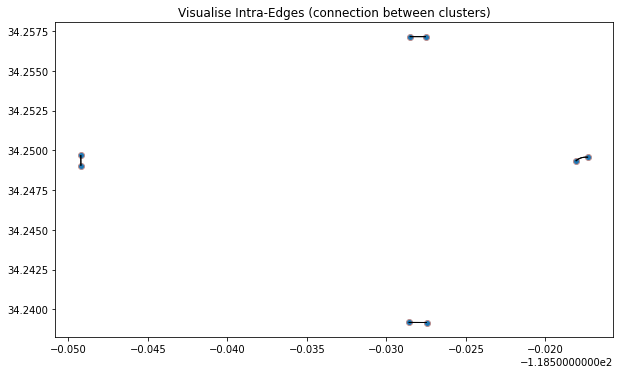

In [7]:
# STEP 4 - pre-processing step to create a high level abstract graph - create intra edges between clusters

# create abstract edges and nodes dataframe
abstract_intra_nodes = pd.DataFrame()
abstract_intra_edges = pd.DataFrame()

# for each neigbor find the edges connecting them. these edges would be entry and exit points of the cluster
for cluster_pair in neighbor:
  opt_length = 9999999
  c_src = cluster_pair[0]
  c_dst = cluster_pair[1]
  print("Find all edges between cluster {} and {}".format(c_src,c_dst))

  #find the nodes in cluster 1
  cluster_p1_graph = ox.graph_from_bbox(cluster_info[c_src][0],cluster_info[c_src][1],cluster_info[c_src][2],cluster_info[c_src][3])
  nodes_p1,_ = ox.graph_to_gdfs(cluster_p1_graph)

  #find the nodes in cluster 2
  cluster_p2_graph = ox.graph_from_bbox(cluster_info[c_dst][0],cluster_info[c_dst][1],cluster_info[c_dst][2],cluster_info[c_dst][3])
  nodes_p2,_ = ox.graph_to_gdfs(cluster_p2_graph)

  # find the edges connecting the clusters using weighted risk factor
  for id_src in nodes_p1.index:
    for id_dst in nodes_p2.index:
      try:
        if edges_nr_all.loc[(id_src, id_dst,0)]['weighted_risk'] < opt_length:
          opt_length = edges_nr_all.loc[(id_src, id_dst,0)]['length']
          opt_id_src = id_src
          opt_id_dst = id_dst
          
      except:
        continue

  abstract_intra_nodes = abstract_intra_nodes.append(pd.DataFrame(nodes_nr_all.loc[(opt_id_src)]).T)
  abstract_intra_nodes.at[opt_id_src,'cluster'] = int(c_src)
  abstract_intra_nodes.at[opt_id_src,'gateway'] = int(c_dst)
 
  abstract_intra_nodes = abstract_intra_nodes.append(pd.DataFrame(nodes_nr_all.loc[(opt_id_dst)]).T)
  abstract_intra_nodes.at[opt_id_dst,'cluster'] = int(c_dst)
  abstract_intra_nodes.at[opt_id_dst,'gateway'] = int(c_src)
  
  abstract_intra_edges = abstract_intra_edges.append(pd.DataFrame(edges_nr_all.loc[(opt_id_src, opt_id_dst,0)]).T)

  abstract_intra_edges = abstract_intra_edges.append(pd.DataFrame(edges_nr_all.loc[(opt_id_dst, opt_id_src,0)]).T)


# define the index in dataframe and clean up
abstract_intra_nodes.index.name = 'osmid' 
abstract_intra_edges.index.names = ['u','v','key']
abstract_intra_nodes_dedup = abstract_intra_nodes.drop_duplicates(subset=['y','x','cluster','gateway'] ,keep='first',inplace=False)


# plot the new abstract graph - inter edges only
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Visualise Intra-Edges (connection between clusters)')
abstract_intra_nodes_ = geopandas.GeoDataFrame(abstract_intra_nodes_dedup,geometry='geometry')
abstract_intra_edges_ = geopandas.GeoDataFrame(abstract_intra_edges,geometry='geometry')

abstract_graph = ox.graph_from_gdfs(abstract_intra_nodes_,abstract_intra_edges_)
#fig, ax = ox.plot_graph(abstract_graph)

a_nodes,a_edges = ox.graph_to_gdfs(abstract_graph)
a_nodes.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
a_edges.plot(ax=ax, linewidth=1, edgecolor='Black')

# check the dataframe
display(abstract_intra_edges.head())
display(abstract_intra_nodes_.head())

processing cluster: 1.0
processing cluster: 2.0
processing cluster: 3.0
processing cluster: 4.0


,,,osmid_left,name,highway,maxspeed,oneway,length,geometry,distance_risk_score,building_risk_score,service,lanes,access,ref,width,bridge,tunnel,combined_risk,weighted_risk
u,v,key,,,,,,,,,,,,,,,,,,
6790327097,364669636,0,999999,Dummy inter edge,Nan,Nan,Nan,2466.091,"LINESTRING (-118.5285283 34.2571518, -118.5492...",0,0,Nan,Nan,Nan,Nan,Nan,Nan,Nan,0,7686.091
364669636,6790327097,0,1000000,Dummy inter edge,Nan,Nan,Nan,2466.091,"LINESTRING (-118.549222 34.2496989, -118.52852...",0,0,Nan,Nan,Nan,Nan,Nan,Nan,Nan,0,7686.091
6317618456,122676367,0,1000001,Dummy inter edge,Nan,Nan,Nan,1773.070,"LINESTRING (-118.5275125 34.2571436, -118.5173...",0,0,Nan,Nan,Nan,Nan,Nan,Nan,Nan,0,6091.070
122676367,6317618456,0,1000002,Dummy inter edge,Nan,Nan,Nan,1773.070,"LINESTRING (-118.5173097 34.2495654, -118.5275...",0,0,Nan,Nan,Nan,Nan,Nan,Nan,Nan,0,6091.070
122977133,652267878,0,1000003,Dummy inter edge,Nan,Nan,Nan,3558.149,"LINESTRING (-118.549216 34.249025, -118.528596...",0,0,Nan,Nan,Nan,Nan,Nan,Nan,Nan,0,11398.149


<AxesSubplot:title={'center':'Visualise Inter-Edges (connection inside clusters)'}>

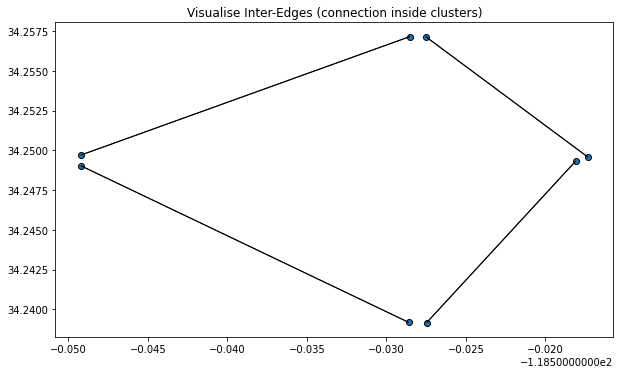

In [52]:
# STEP 5 - pre-processing step to create a high level abstract graph - create inter edges inside the clusters

# Define dataframe columns
cols = abstract_intra_edges.columns
cols = cols.insert(0,'key')
cols = cols.insert(0,'v')
cols = cols.insert(0,'u')

abstract_inter_edges = pd.DataFrame(columns= cols)
osmnid_dummy = 999999

for cluster in [1.0,2.0,3.0,4.0]:
  print('processing cluster:',cluster)
  for ind1,gate_clu1 in abstract_intra_nodes_dedup[abstract_intra_nodes_dedup['cluster'] == cluster]['gateway'].items():
    for ind2,gate_clu2 in abstract_intra_nodes_dedup[abstract_intra_nodes_dedup['cluster'] == cluster]['gateway'].items():
      # if gate_clu1 != gate_clu2 and gate_clu1 < gate_clu2:
        if ind1 != ind2 :
          # Get the nodes x and y co-ordinates
          ind1_x = abstract_intra_nodes_dedup.loc[ind1]['geometry'].centroid.x
          ind2_x = abstract_intra_nodes_dedup.loc[ind2]['geometry'].centroid.x

          ind1_y = abstract_intra_nodes_dedup.loc[ind1]['geometry'].centroid.y
          ind2_y = abstract_intra_nodes_dedup.loc[ind2]['geometry'].centroid.y


          # find the weighted risk factor and length for each inter-edges
          safest_path = nx.astar_path(G=northridge_risk_factors_added_graph, source=ind1, target=ind2, heuristic = None, weight='weighted_risk')
          total_weighted_risk = sum(nx.Graph(northridge_risk_factors_added_graph)[u][v].get('weighted_risk') for u, v in zip(safest_path[:-1], safest_path[1:]))
          total_length = sum(nx.Graph(northridge_risk_factors_added_graph)[u][v].get('length') for u, v in zip(safest_path[:-1], safest_path[1:]))

          # Insert the row in the dataframe
          abstract_inter_edges_append_list = [ind1,ind2,0,osmnid_dummy,'Dummy inter edge','Nan','Nan','Nan',total_length,LineString( [ (ind1_x ,ind1_y ) , (ind2_x , ind2_y)]) ,0,0,'Nan','Nan','Nan','Nan','Nan','Nan','Nan',0,total_weighted_risk]
          osmnid_dummy = osmnid_dummy + 1
          df_length = len(abstract_inter_edges)
          abstract_inter_edges.loc[df_length] = abstract_inter_edges_append_list

# change columns to index
abstract_inter_edges = abstract_inter_edges.set_index(['u', 'v','key'])
display(abstract_inter_edges.head())


# plot the new abstract graph - intra edges
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Visualise Inter-Edges (connection inside clusters)')
abstract_inter_edges_ = geopandas.GeoDataFrame(abstract_inter_edges,geometry='geometry')
abstract_inter_edges_.plot(ax=ax, linewidth=1, edgecolor='Black')
abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='Black')

,,,osmid_left,name,highway,maxspeed,oneway,length,geometry,distance_risk_score,building_risk_score,service,lanes,access,ref,width,bridge,tunnel,combined_risk,weighted_risk
u,v,key,,,,,,,,,,,,,,,,,,
6790327097,6317618456,0,674596857,NaN,footway,NaN,False,93.448,"LINESTRING (-118.52853 34.25715, -118.52755 34...",30,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,259.448
6317618456,6790327097,0,674596857,NaN,footway,NaN,False,93.448,"LINESTRING (-118.52751 34.25714, -118.52755 34...",30,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,259.448
364669636,122977133,0,13348237,Vanalden Avenue,tertiary,30 mph,False,74.936,"LINESTRING (-118.54922 34.24970, -118.54922 34...",26,79,NaN,2,NaN,NaN,NaN,NaN,NaN,105,284.936
122977133,364669636,0,13348237,Vanalden Avenue,tertiary,30 mph,False,74.936,"LINESTRING (-118.54922 34.24903, -118.54922 34...",26,79,NaN,2,NaN,NaN,NaN,NaN,NaN,105,284.936
122676367,123133229,0,13375759,Labrador Street,residential,NaN,False,79.659,"LINESTRING (-118.51731 34.24957, -118.51743 34...",26,107,NaN,2,NaN,NaN,NaN,NaN,NaN,133,345.659


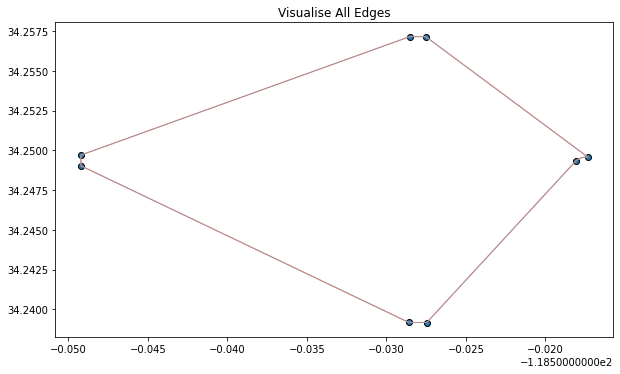

In [53]:
# STEP 6 - combine the edges together and create abstract graph

abstract_edges = abstract_intra_edges.append(abstract_inter_edges)
abstract_edges_ = geopandas.GeoDataFrame(abstract_edges,geometry='geometry')
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Visualise All Edges')
abstract_edges_.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='Black')
display(abstract_edges_.head())

# create abstract graph
abstract_graph = ox.graph_from_gdfs(abstract_intra_nodes_,abstract_edges_)

Shortest Path [6790327097, 6317618456, 122676367, 123133229, 2053235652]


<AxesSubplot:title={'center':'Visualise Path'}>

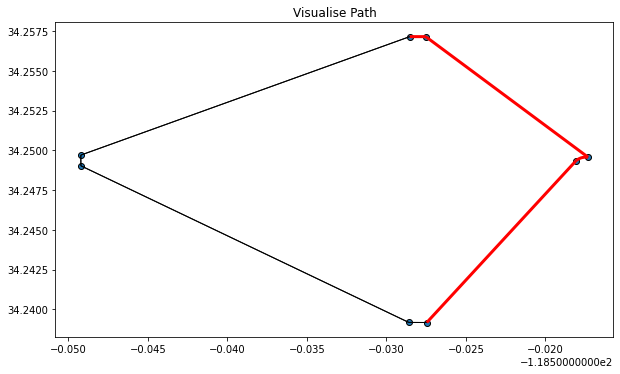

In [54]:
# STEP 7 - find path between points in the abstract graph ( to test the abstract graph )
source_node = 6790327097
destination_node = 2053235652
shortest_path = nx.astar_path(G=abstract_graph, source=source_node, target=destination_node, heuristic = None, weight='length')
print("Shortest Path",shortest_path)

# plot the shortest route 
shortest_path_df = pd.DataFrame()
for ind,se in enumerate(shortest_path):
    if ind != len(shortest_path)-1:
      shortest_path_df = shortest_path_df.append(abstract_edges_.loc[(se,shortest_path[ind+1],0)])

shortest_path_df
shortest_path_df_ = geopandas.GeoDataFrame(shortest_path_df,geometry='geometry')

# plot the new abstract graph - intra edges
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Visualise Path')

abstract_edges_.plot(ax=ax, linewidth=1, edgecolor='Black')
abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='Black')
shortest_path_df_.plot(ax=ax, linewidth=3, edgecolor='Red')

**PART 2 - RUN TIME FIND PATH BETWEEN 2 POINTS USING ABSTRACT AND DETAILED GRAPH**

In [55]:
# STEP 1 - define the functions for part 2

# plot the route
def plot_route(shortest_path,abstract_edges_,abstract_intra_nodes_):

  shortest_path_df = pd.DataFrame()
  for ind,se in enumerate(shortest_path):
      if ind != len(shortest_path)-1:
        shortest_path_df = shortest_path_df.append(abstract_edges_.loc[(se,shortest_path[ind+1],0)])

  shortest_path_df_ = geopandas.GeoDataFrame(shortest_path_df,geometry='geometry')

  # plot the new abstract graph - intra edges
  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title('Visualise Inter-Edges (connection inside clusters)')

  abstract_edges_.plot(ax=ax, linewidth=1, edgecolor='Black')
  abstract_intra_nodes_.plot(ax=ax, linewidth=1, edgecolor='Black')
  shortest_path_df_.plot(ax=ax, linewidth=3, edgecolor='Red')

# find the distance
def find_close_node_in_abstract_graph(abstract_intra_nodes_,source_node):
  shortest_dist = 9999999

  for osmid,node_details in abstract_intra_nodes_.iterrows():
    e_dist = math.sqrt((nodes_nr_all.loc[(source_node)]['x'] - node_details['x'])**2 + (nodes_nr_all.loc[(source_node)]['y'] - node_details['y'])**2)
    # shortest euclidian distance
    if e_dist < shortest_dist:
      shortest_dist = e_dist
      closet_source_node = osmid

  print("closest_node is ",closet_source_node)
  return closet_source_node  

In [56]:
# STEP 2 - translating address of two points in the graph into correspoding latitude and longitude values. This is common for all path finding algorithms
import warnings
warnings.filterwarnings("ignore")

# Choose source and destination
geolocator = Nominatim(user_agent="Nominatim")
source_latlon = geolocator.geocode("19130 Tulsa St, Northridge, CA 91326")
destination_latlon = geolocator.geocode("7741 Hayvenhurst Ave, Van Nuys, CA 91406")
source_point = (source_latlon.latitude, source_latlon.longitude)
destination_point = (destination_latlon.latitude, destination_latlon.longitude)

source_node, source_dist = ox.get_nearest_node(northridge_risk_factors_added_graph,source_point,return_dist=True)
destination_node, destination_dist = ox.get_nearest_node(northridge_risk_factors_added_graph,destination_point,return_dist=True)

print("Source:" ,source_node)
print("Destination:",destination_node)

Source: 122698946
Destination: 6514553211


In [61]:
# STEP 3 - Find the route using detailed and abstract graph and track time - Hierarchical A* algorithm
start_time = time.time()

# Find the closest node to source and destination in the abstract graph
source_abs_graph_node = find_close_node_in_abstract_graph(abstract_intra_nodes_,source_node)
dest_abs_graph_node = find_close_node_in_abstract_graph(abstract_intra_nodes_,destination_node)


# Find route between nodes of abstract graph
shortest_path_abs = nx.astar_path(G = abstract_graph, source=source_abs_graph_node, target=dest_abs_graph_node, heuristic = None, weight='weighted_risk')
print("MIDDLE ROUTE - shortest_path_abs",shortest_path_abs)

# Find the path between source_abs_graph_node and source node using original graph
shortest_path_source_to_source_abs = nx.astar_path(G =northridge_risk_factors_added_graph,source=source_node, target=source_abs_graph_node, heuristic = None, weight='weighted_risk')
print("FIRST HALF - shortest_path_source_to_source_abs",shortest_path_source_to_source_abs)

# Find the path between dest_abs_graph_node and dest node using original graph
shortest_path_dest_to_dest_abs = nx.astar_path(G =northridge_risk_factors_added_graph,source=dest_abs_graph_node, target=destination_node, heuristic = None, weight='weighted_risk')
print("SECOND HALF - shortest_path_dest_to_dest_abs",shortest_path_dest_to_dest_abs)


# Join the Shortest Route together
complete_path  = shortest_path_source_to_source_abs  + shortest_path_abs[1:-1] + shortest_path_dest_to_dest_abs
print('COMPLETE ROUTE -',complete_path)

hierarch_time = (time.time() - start_time)
print("Total Time in secs:",hierarch_time)

closest_node is  364669636
closest_node is  2053235652
MIDDLE ROUTE - shortest_path_abs [364669636, 122977133, 652267878, 2053235652]
FIRST HALF - shortest_path_source_to_source_abs [122698946, 122960456, 122977106, 122977109, 7241989387, 122977113, 7241989385, 122575923, 122905430, 122905378, 122977116, 122917083, 122977121, 7159751452, 122977122, 7159751450, 122977124, 122849467, 122977127, 122977129, 7159751474, 122977131, 7159751478, 364669636]
SECOND HALF - shortest_path_dest_to_dest_abs [2053235652, 4593858392, 4593858391, 4593858390, 6654131523, 1876988347, 2060911059, 6680464355, 4714496876, 4707680358, 1706546998, 6654413470, 6654413471, 6030405879, 4696399369, 5690175270, 6030406185, 4696399227, 6026592130, 122720268, 6026592133, 122720265, 122582660, 122582657, 7884291497, 122582654, 367739509, 122582650, 122582647, 294188574, 122582641, 122910180, 123299796, 122630447, 7250041998, 7250042003, 7250042005, 6672917609, 6672917601, 6672917610, 4821318866, 363996464, 7520944648,

In [62]:
# STEP 4 - Find the route using A* algorithm
start_time = time.time()
safest_path = nx.astar_path(G=northridge_risk_factors_added_graph, source=source_node, target=destination_node, heuristic = None, weight='weighted_risk')
print("A* safest path",safest_path)
A_time = (time.time() - start_time)
print("Total Time in secs:",A_time)

A* safest path [122698946, 122960456, 122977106, 122977109, 7241989387, 122977113, 7241989385, 6412684586, 6412684594, 6571814477, 6318816406, 7241989384, 4269314469, 4269314487, 4269314459, 6477025043, 6477025044, 6443646422, 6788054262, 6788054263, 6788054259, 6477023673, 6477023670, 6477023669, 1935998482, 123159101, 6569351854, 6569351853, 6569351860, 6654442470, 6317618410, 6317548766, 4269314403, 4269314389, 8609738240, 123014512, 6654270703, 6654270704, 6028486051, 6028035402, 6028486037, 6028486041, 6028589505, 6028034850, 7904814030, 7904814019, 122720280, 5690175268, 7136746850, 7136746849, 6412999368, 5690175271, 6412999369, 5690125462, 6652182137, 7305109840, 7305109833, 7305109832, 5690175267, 365353136, 1707754916, 6680418913, 122598550, 6652182134, 6468789572, 6479937180, 7884291507, 6026592146, 6026592147, 6463325195, 122746867, 652286198, 6027957679, 652286201, 123175042, 123455355, 294188577, 294188574, 122582641, 122910180, 123299796, 122630447, 7250041998, 725004200

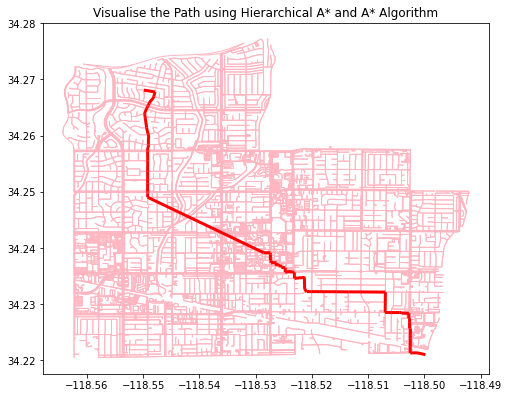

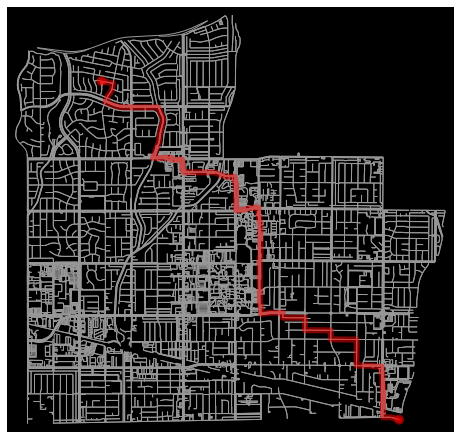

In [72]:
# STEP 4  - Plot Route for both A* and Hirarchical A* Algorithm

# combine dummy inter edges into original edges
#edges_nr_all_complete = edges_nr_all.append(abstract_inter_edges_)

# create graph again
#combined_graph = ox.graph_from_gdfs(nodes_nr_all,edges_nr_all_complete)

# plot this graph
#fig, ax = ox.plot_graph(combined_graph)
# plot route in this graph
#fig, ax = ox.plot_graph_route(combined_graph, complete_path, route_linewidth=6, node_size=0, bgcolor='k')

complete_path_df = pd.DataFrame()
for ind,se in enumerate(complete_path):
  if ind != len(complete_path)-1:
    try:
      complete_path_df = complete_path_df.append(abstract_edges_.loc[(se,complete_path[ind+1],0)])
    except:
      complete_path_df = complete_path_df.append(edges_nr_all.loc[(se,complete_path[ind+1],0)])

complete_path_df_ = geopandas.GeoDataFrame(complete_path_df,geometry='geometry')

# plot Hieararchical A* path
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Visualise the Path using Hierarchical A* and A* Algorithm')
edges_nr_all.plot(ax=ax, linewidth=1, edgecolor='#ffb6c1')
complete_path_df_.plot(ax=ax, linewidth=3, edgecolor='Red')

# plot A* path
fig, ax = ox.plot_graph_route(northridge_risk_factors_added_graph, safest_path, route_linewidth=6, node_size=0, bgcolor='k')